In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import numpy
import h5py

from PIL import Image, ImageSequence

import cv2

import torchtext.data as data
import torchtext.datasets as datasets

import os
import tensorwatch as tw

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import visdom

In [2]:
import bcolz
import numpy as np
import pickle
from segtok.tokenizer import split_contractions
from segtok.tokenizer import word_tokenizer

In [3]:
words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'./Data/6B.100.dat', mode='w')

with open(f'./Data/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'./Data/6B.100.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'./Data/6B.100_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'./Data/6B.100_idx.pkl', 'wb'))

In [4]:
vectors = bcolz.open(f'./Data/6B.100.dat')[:]
words = pickle.load(open(f'./Data/6B.100_words.pkl', 'rb'))
word2idx = pickle.load(open(f'./Data/6B.100_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [5]:
test_ocr = 'I love berlin'
tokenized_ocr = split_contractions(word_tokenizer(test_ocr))
print(tokenized_ocr)

['I', 'love', 'berlin']


In [6]:
hdf5_file='./HDF5_files/hdf5_10.hdf5'
h5_file = h5py.File(hdf5_file, "r")
ocr = h5_file.get('train_ocrs')

In [7]:
contractions_full = []
for counter, text in enumerate(ocr):
    contractions = split_contractions(word_tokenizer(text))
    for element in contractions:
        element = element.lower()
        contractions_full.append(element)
target_vocab = contractions_full
print(contractions_full)

['oe', 'the', 'sunday', 'star', 'washington', ',', 'd.c.', 'june', 'y', '1963', 'heart', 'association', 'moves', 'to', 'reduce', 'cigarette', 'use', 'new', 'yore', ',', 'june', '8', '(', 'ap', ')', '—', 'the', 'american', 'heart', 'associa-ulon', 'went', 'on', 'record', 'today', 'foi', 'the', 'first', 'time', 'in', 'favor', 'of', 'acthe', 'steps', 'to', 'discourage', 'clparettr', 'smoking', 'on', 'the', 'ground', 'it', 'fr', 'heimtul', 'to', 'health', ',', 'the', 'action', 'by', 'the', 'board', 'of', 'directors', 'opens', 'the', 'way', 'fc', 'the', 'asvocjution', 'to', 'work', 'with', '«', 'ther', 'proips', 'in', 'campaizns', 'fiist', 'poking.', 'the', 'association', 'said', 'a', 'i56', '¢', 'wport', 'by', '4', 'spectal', 'committer', 'of', 'physicians', 'and', 'scientists', 'shawed', 'that', 'dcath', 'rates', 'ir', 'middle-aged', 'men', 'from', 'heart', 'attacks', 'were', '60', 'to', '150', 'per', 'cen', ':', 'hicher', 'among', 'heavy', 'ciynrett', ':', 'snvakers', 'than', 'among', 'n

In [8]:
emb_dim =100
matrix_len = len(target_vocab)
print(matrix_len)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

6020


In [9]:
corpus2idx = {}
for i, word in enumerate(target_vocab):
    corpus2idx[word] = i
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [10]:
def create_emb_layer(weights_matrix, non_trainable=False):
    print(type(weights_matrix))
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(weights_matrix)})
    #torch.tensor(emb_layer.load_state_dict({'weight': weights_matrix}), dtype=torch.long)
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [11]:
# Dataset creation with image directory, image -> 'RGB' -> transformed to Mobilenetv2 input, Ocr,
# Class and Segmentation

data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])}
#Independent train and test transformations can be done

class H5Dataset(Dataset):

    def __init__(self, hdf5_file, data_transforms):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.h5_file = h5py.File(hdf5_file, "r")
        self.data = self.h5_file.get('train_img')
        self.target = self.h5_file.get('train_labels')
        self.ocr = self.h5_file.get('train_ocrs')
        self.data_transforms = data_transforms

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        
        img = self.data[idx,:,:,:],
        img = Image.fromarray(img[0].astype('uint8'), 'RGB')
        #doc_class = torch.from_numpy(self.target[idx,:,:,:]).float()
        doc_class = self.target[idx]
        doc_class = doc_class.astype(np.uint8)
        doc_class = torch.tensor(doc_class)
        
        ocr_text = self.ocr[idx]
        

        if self.data_transforms is not None:
            try:
                image = self.data_transforms(img)
            except:
                print("Cannot transform image: {}")
        
        ocr = ocr_text
        tokenization_ocr_full = []
        tokenization_ocr = split_contractions(word_tokenizer(ocr))
        for element in tokenization_ocr:
            element = element.lower()
            tokenization_ocr_full.append(element)
        
        #print(tokenization_ocr_full[0])
        #print(tokenization_ocr_full)
        
        
        sample = {'image': image, 'class': doc_class, 'ocr': tokenization_ocr_full}

        return sample

In [12]:
h5_dataset = H5Dataset(hdf5_file='./HDF5_files/hdf5_10.hdf5', data_transforms=data_transforms['train'])

In [13]:
dataloader = DataLoader(h5_dataset, batch_size=1,
                        shuffle=False, num_workers=1)

## CNN Text model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class CNN_Text(nn.Module):
    
    def __init__(self, weights_matrix):
        super(CNN_Text, self).__init__()
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        
        D = embedding_dim
        #V = args.embed_num
        #D = 2048 #embed_dim, 4196 for doc_embeddings
        C = 10 #class_num
        Ci = 1
        Co = 100 #kernel_num -> number of kernel with the same size
        Ks = [3,4,5] #kernel_sizes -> size = number of words

        #self.embed = nn.Embedding(V, D)
        # self.convs1 = [nn.Conv2d(Ci, Co, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        
        
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(Ks)*Co, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        
        #Output will be size (1,Ks*Co) -> Maxpool will get one ĉ value =  max(c_1,c_2...), where c_i is
        #the result of the convolution operation of the kernel over the input
        
        return x

    def forward(self, x):
        #x = self.embed(x)  # (N, W, D)
        
        #if self.args.static:
            #x = Variable(x)
        
        #print('CNN Before embedding',x.shape)
        
        x = self.embedding(x)
        
        #print('CNN After embedding',x.shape)

        x = x.unsqueeze(0)  # (N, Ci, W, D)
        x = x.unsqueeze(0)
        #print('CNN unsqueeze',x.shape)
        
        
        #print(x.shape)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        

        x = torch.cat(x, 1) #[1,100] + [1,100] + [1,100] = [1,300]
        
        #print('After cat', x.shape)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = x
        #logit = self.fc1(x)  # (N, C)
        return logit

## Mega NN

In [15]:
import torch.nn as nn
import math

__all__ = ['MobileNetV2', 'mobilenetv2_19']

class Bottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None, expansion=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, inplanes*expansion, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inplanes*expansion)
        self.conv2 = nn.Conv2d(inplanes*expansion, inplanes*expansion, kernel_size=3, stride=stride,
                               padding=1, bias=False, groups=inplanes*expansion)
        self.bn2 = nn.BatchNorm2d(inplanes*expansion)
        self.conv3 = nn.Conv2d(inplanes*expansion, planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MobileNetV2(nn.Module):

    def __init__(self, block, layers, text_model, num_classes=16):
        self.inplanes = 32
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1, expansion = 1)
        self.layer2 = self._make_layer(block, 24, layers[1], stride=2, expansion = 6)
        self.layer3 = self._make_layer(block, 32, layers[2], stride=2, expansion = 6)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2, expansion = 6)
        self.layer5 = self._make_layer(block, 96, layers[4], stride=1, expansion = 6)
        self.layer6 = self._make_layer(block, 160, layers[5], stride=2, expansion = 6)
        self.layer7 = self._make_layer(block, 320, layers[6], stride=1, expansion = 6)
        self.conv8 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, bias=False)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.conv9 = nn.Conv2d(1280,num_classes, kernel_size=1, stride=1, bias=False)
        
        #Added
        #Fully connected
        self.fc1 = nn.Linear(310, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        self.text_model = text_model
                

    #def conv_and_pool(self, x, conv):
        #x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        #x = F.max_pool1d(x, x.size(2)).squeeze(2)
        #return x

    def _make_layer(self, block, planes, blocks, stride, expansion):

        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes),
        )

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, downsample=downsample, expansion=expansion))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, expansion=expansion))

        return nn.Sequential(*layers)

    def forward(self, x, x2): #NN input -> Image + ocr text
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        x = self.conv8(x)
        x = self.avgpool(x)
        x = self.conv9(x)
        
        #print('conv9 output', x.shape)
        
        x = x.view(x.size(0),-1)
        
        
        #print(x.size(0))#1Xnum_classes size
        
        #print('mobilenet output', x.shape)
        
        
        x2 = self.text_model(x2)
        
        #print('CNN Text output',x2.shape)
        
        #print('Text model output (without last layer)', x2.shape)
                
        x2 = torch.cat((x,x2),1)
        
        x2 = self.fc1(x2)
        
        #print('MegaNet output',x2)
        
        #print('Output shape', x2.shape)

        return x2


def mobilenetv2_19(text_model, **kwargs):
    """Constructs a MobileNetV2-19 model.
    """
    model = MobileNetV2(Bottleneck, [1, 2, 3, 4, 3, 3, 1], text_model, **kwargs)
    return model

## Mega NN training

In [16]:
# get model
text_model = CNN_Text(weights_matrix)
model = mobilenetv2_19(text_model, num_classes = 10)
#print(model)
# define loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00004)

<class 'numpy.ndarray'>


In [17]:
corpus2idx['oe']

3103

[Epoch 0/15], loss 3.078718662261963
[Epoch 1/15], loss 4.647356986999512
[Epoch 2/15], loss 1.0268683433532715
[Epoch 3/15], loss 2.71111798286438
[Epoch 4/15], loss 0.8710904121398926
[Epoch 5/15], loss 0.40261173248291016
[Epoch 6/15], loss 0.9874954223632812
[Epoch 7/15], loss 0.1757526397705078
[Epoch 8/15], loss 0.35725927352905273
[Epoch 9/15], loss 0.11348152160644531
[Epoch 10/15], loss 0.021294593811035156
[Epoch 11/15], loss 0.020475387573242188
[Epoch 12/15], loss 0.03648185729980469
[Epoch 13/15], loss 0.014877796173095703
[Epoch 14/15], loss 0.06191205978393555


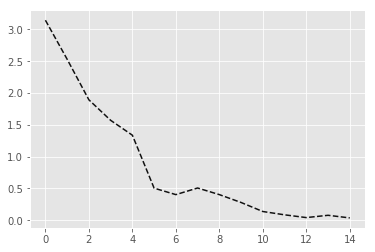

In [19]:

max_epochs = 15
optimizer = optimizer_ft
batch_size=1
running_loss = 0.0
steps = 0
loss_values = []
epoch_values = []
# Loop over epochs
for epoch in range(max_epochs):
    running_loss = 0
    # Training
    for local_batch in dataloader:
        word_list = []
        for i, word in enumerate(local_batch['ocr']):
            word = local_batch['ocr'][i][0]
            word_list.append(word)
        
            
        #ocr_text = torch.tensor([corpus2idx[w] for w in local_batch['ocr']], dtype=torch.long)
        ocr_text = [corpus2idx[w] for w in word_list]
        ocr_text = torch.tensor(ocr_text)
        #print(ocr_text.shape)
        image, labels = Variable(local_batch['image']), Variable(local_batch['class'])
        # zero the parameter gradients
        optimizer.zero_grad()
        #print(local_batch['image_dir'])

        # forward
        outputs = model(image, ocr_text)
        _, preds = torch.max(outputs.data, 1)
        #print(preds, labels.long())
        loss = criterion(outputs, labels.long())
        #print(outputs)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()
        #running_loss += loss.data[0]
        steps += 1
        if steps % 100 == 0:
            #save(model,'./snapshot/', 'model', steps)
            pass
        
        running_loss += loss.item()
        
    loss_values.append(running_loss/10)
    epoch_values.append(epoch)

    #print(outputs)
    print('[Epoch {}/{}], loss {}'.format(
                      epoch, max_epochs,loss_values))


plt.plot(epoch_values, loss_values, '--', color="#111111",  label="Training score")
        
#save(model,'./snapshot/', 'model', steps)